## Imports / Helper Functions / Global Variables

In [31]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from typing import List
from collections import Counter
import seaborn as sns
from tqdm import tqdm

In [32]:
# shorthand for datetime column

DATE_COL = 'Citation Issued DateTime'

In [33]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

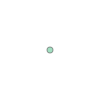

In [34]:
# helper functions for loading in US Census Bureau Geocoding data. This helps correct for ~10k observations with incorrect geolocation.

# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [35]:
# TODO: correct all "lock Of" addresses.

# feat_df[feat_df.street_id.str.contains('lock Of')]

In [36]:
def load_geocoder_data(csv_path='../data/chinook_ct_correct.csv'):
    geo = pd.read_csv(csv_path, header=None)
    geo = geo[geo[2] == 'Match']
    geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
    geo = geo[[1, 5]]
    geo.columns = ['street', 'geom']
    geo.street = geo.street.apply(inv_correct_numbered_streets)
    geo.geom = geo.geom.apply(coord_string_to_point)
    return geo

## Load Data and Fix Incorrect Data

In [37]:
geo_df = load_geocoder_data()
geo_df.head()

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)


In [38]:
# create dictionary from pandas dataframe. 

geo_dict = pd.Series(geo_df.geom.values,index=geo_df.street).to_dict()

In [39]:
geo_df.shape

(2500, 2)

In [40]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,04/20/2022 12:10:00 PM,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,06/17/2022 04:12:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,04/23/2022 03:13:00 PM,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,02/22/2022 11:54:00 AM,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,02/17/2022 01:39:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [41]:
# filter to only meter violations

df = df[(df["Violation Description"].str.contains("METER")) | (df["Violation Description"].str.contains("MTR"))]

In [42]:
df["Violation Description"].value_counts()

MTR OUT DT    114608
METER DTN      56350
OT MTR PK        229
Name: Violation Description, dtype: int64

In [43]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [44]:
# TODO: rewrite this using np.where or pandas where 
# TODO: use a better geocoder to fix more rows.

def fix_geom(row):
    if row['Citation Location'] in geo_dict:
        return geo_dict[row['Citation Location']]
    return row['geom']

df['geom'] = df.apply(fix_geom, axis=1)

## Add / Modify Dataframe Columns

In [45]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

In [46]:
# add auxillary date attribute columns based on the datetime. 

df['citation_day'] = df[DATE_COL].dt.day_name()
df['citation_hour'] = df[DATE_COL].dt.hour
df['citation_date'] = df[DATE_COL].dt.date

In [47]:
has_location_string = df[~df['Citation Location'].isnull()]

## Spatial Join

In [48]:
# load dataframe of street segments

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

In [49]:
# TODO: technically should project into a flat geometry in order to get more accurate distances  

# unique_streets = street_df.drop_duplicates(subset='Line')
# unique_streets = unique_streets[['Corridor', 'Limits', 'Line']]

# # save copy of geom column because it will be destroyed by projection / join.
# unique_streets['street_geom_3d'] = unique_streets['Line']
# unique_streets['street_length'] = unique_streets.street_geom_3d.apply(lambda x: x.length)

unique_streets = pd.read_csv("../data/unique_streets.csv")

unique_streets['geom'] = unique_streets.Line.apply(wkt.loads)
unique_streets = gpd.GeoDataFrame(unique_streets, geometry='geom')
unique_streets.crs = 'EPSG:4326'

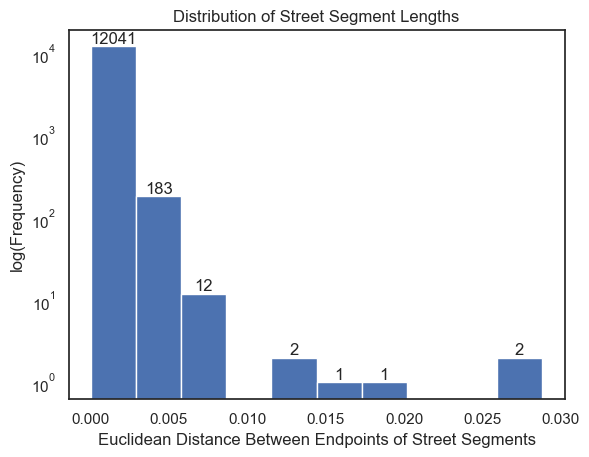

In [50]:
sns.set()
sns.set_theme(style='white')
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 0})
ax = unique_streets.street_length.plot(kind="hist", logy = True)
ax.bar_label(ax.containers[0], label_type="edge");

plt.xlabel("Euclidean Distance Between Endpoints of Street Segments")
plt.ylabel("log(Frequency)")
plt.title("Distribution of Street Segment Lengths");
plt.show()
sns.reset_orig()


In [51]:
joined = gpd.sjoin_nearest(df, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(171601, 21)

In [52]:
# TODO: figure out how to resolve points that get mapped to multiple streets. for now, seems like only a small number have this problem so we ignore it.

has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]

## Group and Cluster

In [53]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [82]:
feat_df = joined[['citation_date', 'street_id', DATE_COL, 'Citation Location', 'geom', 'citation_day', 'citation_hour', 'street_geom_3d']]

In [55]:
unique_streets = pd.read_csv('../data/street_sweeping.csv')
unique_streets = unique_streets[~unique_streets.Line.isnull()]
unique_streets.loc[:, 'Line'] = unique_streets.Line.apply(wkt.loads)
unique_streets = gpd.GeoDataFrame(unique_streets, geometry='Line')
unique_streets.crs = 'EPSG:4326'

In [56]:
# did not use

# unique_streets[['X1', 'Y1']] = unique_streets['Line'].apply(lambda x: pd.Series([x.coords[0][0], x.coords[0][1]]))
# unique_streets[['X2', 'Y2']] = unique_streets['Line'].apply(lambda x: pd.Series([x.coords[1][0], x.coords[1][1]]))

# unique_streets['Endpoint1'] = unique_streets['X1'].astype(str) + " " + unique_streets['Y1'].astype(str)
# unique_streets['Endpoint2'] = unique_streets['X2'].astype(str) + " " + unique_streets['Y2'].astype(str)

In [57]:
# unique_streets['segment_id'] = unique_streets['Corridor'] + ' ' + unique_streets['Limits']

In [58]:
def get_intersect_st(df, segment_id):
    # getting endpoints of initial condition
    Endpoint1 = df[df['segment_id'] == segment_id]['Endpoint1'].iloc[0]
    Endpoint2 = df[df['segment_id'] == segment_id]['Endpoint2'].iloc[0]

    # now we need to get the segment_id's of streets that share the same endpoints
    unique_segments1 = df[(df['Endpoint1'] == Endpoint1) | (df['Endpoint1'] == Endpoint2)]['segment_id'].unique()
    unique_segments2 = df[(df['Endpoint2'] == Endpoint1) | (df['Endpoint2'] == Endpoint2)]['segment_id'].unique()

    # now return a concatenated list of segments into one vector
    unique_segments = np.unique(np.concatenate((unique_segments1, unique_segments2)))

    # Remove current segment from intersection
    unique_segments = unique_segments[unique_segments != segment_id]

    return(unique_segments)

# get_intersect_st(unique_streets, '22nd St Mission St  -  Bartlett St')

In [59]:
# unique_streets['adjacent_streets'] = unique_streets['segment_id'].apply(lambda segment_id: get_intersect_st(unique_streets, segment_id))

In [60]:
# adjacent_dict = pd.Series(unique_streets.adjacent_streets.values,index=unique_streets.segment_id).to_dict()

In [83]:
feat_df['time_bin'] = feat_df[DATE_COL].dt.floor("15min").dt.time.astype(str)

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [65]:
# group by citation date
# for each adjacent street, we get all time bin values for that street on that day (in the group by)
# get new row based on current row, but replace time bin + duplicate 

def flatten(l):
    return [item for sublist in l for item in sublist]

def augment_group(group):
    unique_adjacent_streets = list(set(flatten(group.street_id.apply(lambda street_id: adjacent_dict[street_id]))))
    extra_rows = []
    for street in unique_adjacent_streets:
        adjacent_streets = adjacent_dict[street]
        extra = group[group['street_id'].isin(adjacent_streets)]
        extra['street_id'] = street
        extra_rows.append(extra)
    return extra_rows

In [66]:
# for spatial smoothing only

# antipattern 
# aug_list = []

# for group_name, df_group in tqdm(feat_df.groupby('citation_date')):
#     aug = augment_group(df_group)
#     if len(aug) > 0:
#         aug_list.extend(aug)

In [ ]:
# antipattern!

# augs = pd.concat(aug_list)

In [ ]:
# feat_df = pd.concat([feat_df, augs])
# feat_df.shape

In [84]:
all_bins = sorted(feat_df['time_bin'].unique())

In [93]:
feat_df[(feat_df['street_id'] == 'Zoe St Freelon St  -  Brannan St') & (feat_df['citation_day'] == 'Saturday')]

,citation_date,street_id,Citation Issued DateTime,Citation Location,geom,citation_day,citation_hour,street_geom_3d,time_bin
329991,2022-02-26,Zoe St Freelon St - Brannan St,2022-02-26 14:01:00,440 BRANNAN ST,POINT (-122.39568 37.77946),Saturday,14,"LINESTRING (-122.395835332739 37.779720604982,...",14:00:00


In [81]:
# keep each entry for a particular time bin on a particular date + street

feat_df = feat_df.drop_duplicates(['citation_date', 'street_id', 'time_bin'])
binned_grouped = feat_df.groupby(['street_id', 'citation_day'])['time_bin'].agg(' '.join)

In [69]:
binned_grouped

street_id                         citation_day
01st St Elim St  -  Mission St    Friday                        12:00:00 11:45:00 12:00:00 11:30:00
                                  Monday                                          12:00:00 14:30:00
                                  Thursday        12:30:00 12:15:00 11:15:00 12:15:00 11:00:00 1...
                                  Tuesday              11:45:00 11:00:00 13:00:00 12:30:00 14:15:00
                                  Wednesday                     14:15:00 12:15:00 12:15:00 12:00:00
                                                                        ...                        
Zoe St Freelon St  -  Brannan St  Monday                                          16:45:00 19:00:00
                                  Saturday                                                 14:00:00
                                  Thursday                      13:15:00 12:15:00 13:45:00 17:00:00
                                  Tuesday            

In [94]:
def bin_string_to_counter(bin_string):
    bin_counter = Counter(all_bins)
    bin_counter.update(bin_string.split(' '))
    return bin_counter

agg_counts = binned_grouped.apply(bin_string_to_counter).groupby(['street_id', 'citation_day']).sum()

In [104]:
# sanity check

# g = agg_counts.reset_index()
# g[g['street_id'] == '01st St Elim St  -  Mission St'].iloc[0]['time_bin']

In [105]:
unique_street_names = agg_counts.index.get_level_values(0).unique()

In [106]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [107]:
from datetime import date, timedelta

df.sort_values("Citation Issued DateTime").head()
sdate = date(2022,1,1)   # start date
edate = date(2023,2,20)   # end date
dates = pd.date_range(sdate, edate-timedelta(days=1),freq='d')
dates_counts = dates.day_name().value_counts().reindex(weekdays)

In [116]:
df_list = []

for name in tqdm(unique_street_names):
    t = agg_counts.xs(name, level=0, drop_level=False).reset_index().set_index('citation_day').reindex(weekdays, fill_value=Counter(all_bins))
    t.street_id = name
    dist_df = pd.concat([t.reset_index(), (pd.DataFrame.from_records(t.time_bin) - 1).divide(dates_counts.values, axis = 0)], axis=1)
    df_list.append(dist_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2138/2138 [00:04<00:00, 431.10it/s]


In [ ]:
df_list

KeyboardInterrupt: 

In [119]:
dates_counts.values

array([59, 59, 59, 59, 59, 60, 60])

In [109]:
all_dists = pd.concat(df_list)

all_dists.head()

#all_dists.iloc[:, 3:] = np.log(all_dists.iloc[:, 3:]).replace(-np.Inf, np.nan).fillna(0)



,citation_day,street_id,time_bin,00:00:00,07:00:00,07:15:00,07:30:00,07:45:00,08:00:00,08:15:00,08:30:00,08:45:00,09:00:00,09:15:00,09:30:00,09:45:00,10:00:00,10:15:00,10:30:00,10:45:00,11:00:00,11:15:00,11:30:00,11:45:00,12:00:00,12:15:00,12:30:00,12:45:00,13:00:00,13:15:00,13:30:00,13:45:00,14:00:00,14:15:00,14:30:00,14:45:00,15:00:00,15:15:00,15:30:00,15:45:00,16:00:00,16:15:00,16:30:00,16:45:00,17:00:00,17:15:00,17:30:00,17:45:00,18:00:00,18:15:00,18:30:00,18:45:00,19:00:00,19:15:00,19:30:00,19:45:00,20:00:00,20:15:00,20:30:00,20:45:00,21:00:00,21:15:00,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00
0,Monday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Tuesday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.000000,0.000000,0.016949,0.000000,0.000000,0.016949,0.0,0.016949,0.0,0.0,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Wednesday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.016949,0.033898,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Thursday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.016949,0.000000,0.000000,0.000000,0.050847,0.016949,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Friday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.016949,0.016949,0.033898,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
pd.set_option('display.max_columns', 500)

all_dists[(all_dists.street_id == '01st St Elim St  -  Mission St') & (all_dists.citation_day == 'Friday')]

,citation_day,street_id,time_bin,00:00:00,07:00:00,07:15:00,07:30:00,07:45:00,08:00:00,08:15:00,08:30:00,08:45:00,09:00:00,09:15:00,09:30:00,09:45:00,10:00:00,10:15:00,10:30:00,10:45:00,11:00:00,11:15:00,11:30:00,11:45:00,12:00:00,12:15:00,12:30:00,12:45:00,13:00:00,13:15:00,13:30:00,13:45:00,14:00:00,14:15:00,14:30:00,14:45:00,15:00:00,15:15:00,15:30:00,15:45:00,16:00:00,16:15:00,16:30:00,16:45:00,17:00:00,17:15:00,17:30:00,17:45:00,18:00:00,18:15:00,18:30:00,18:45:00,19:00:00,19:15:00,19:30:00,19:45:00,20:00:00,20:15:00,20:30:00,20:45:00,21:00:00,21:15:00,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00
4,Friday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
all_dists[all_dists.street_id == '01st St Elim St  -  Mission St'].drop(['citation_day', 'street_id', 'time_bin'], axis=1).max().max()

3

In [78]:
all_dists.to_csv("../data/prob_e_and_i.csv", index = False)

In [141]:
truncated = pd.concat([all_dists.iloc[:,0:2], all_dists.iloc[:,12:48]], axis=1)

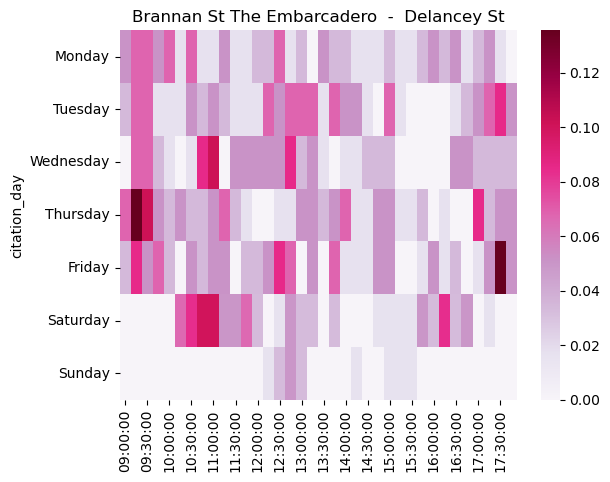

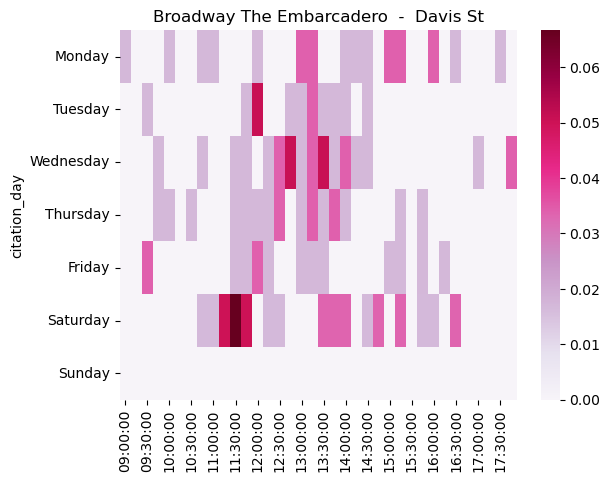

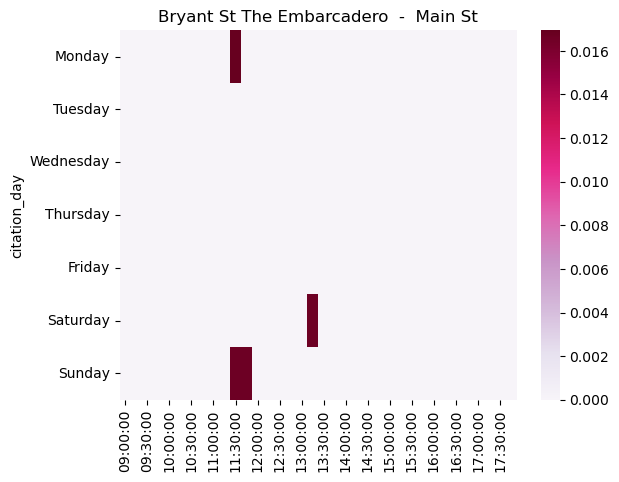

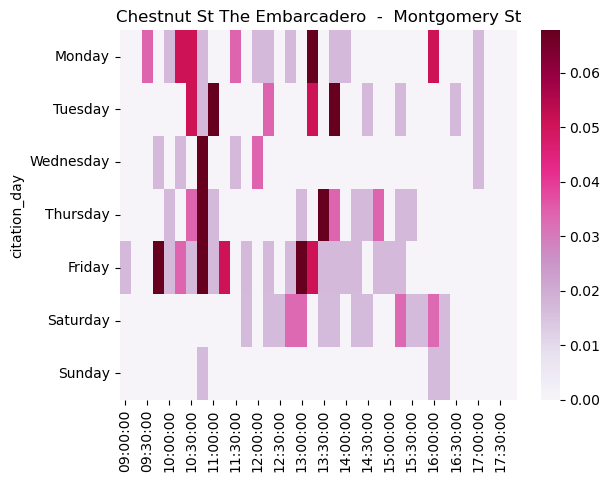

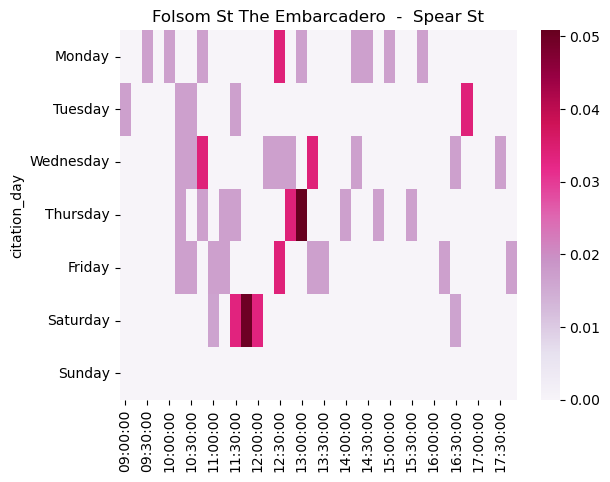

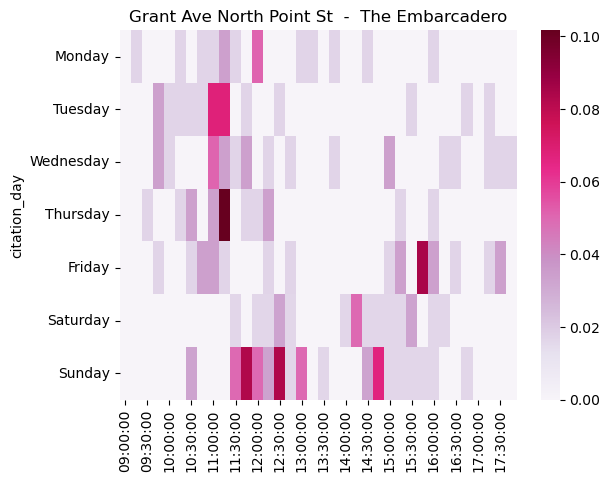

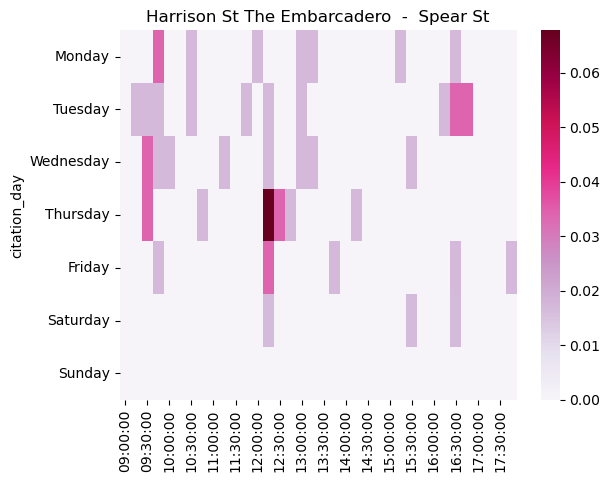

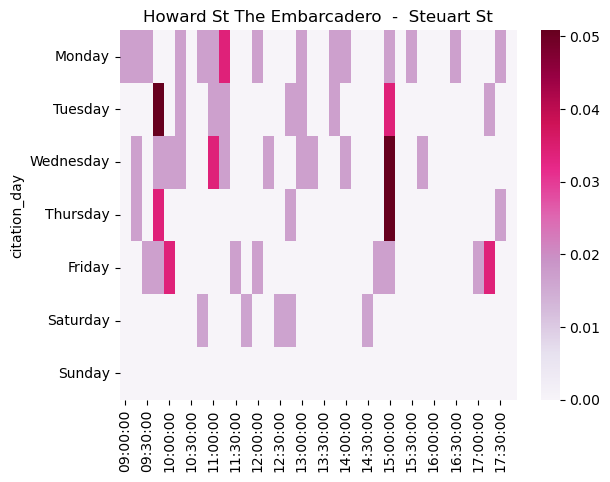

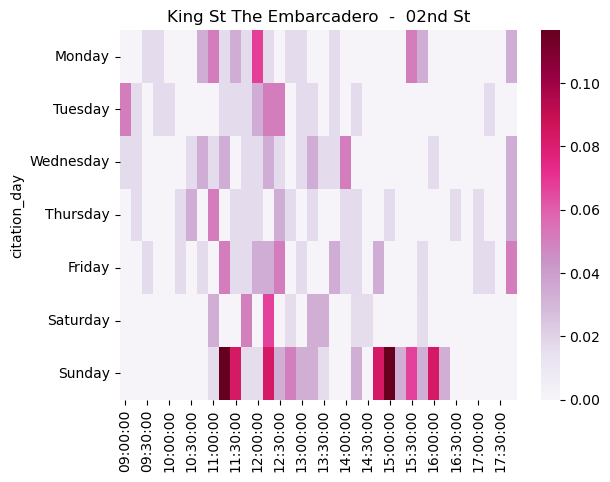

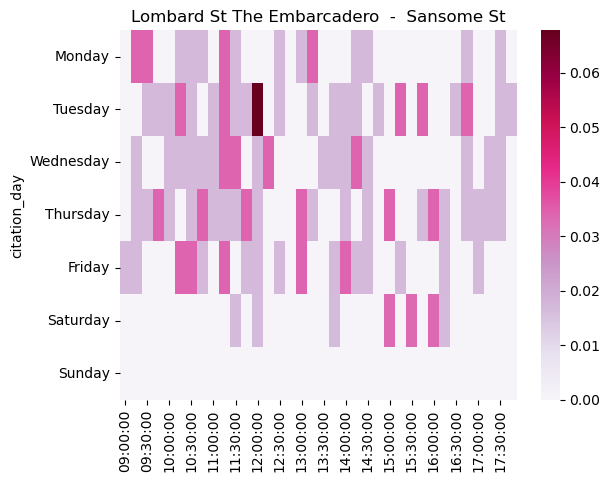

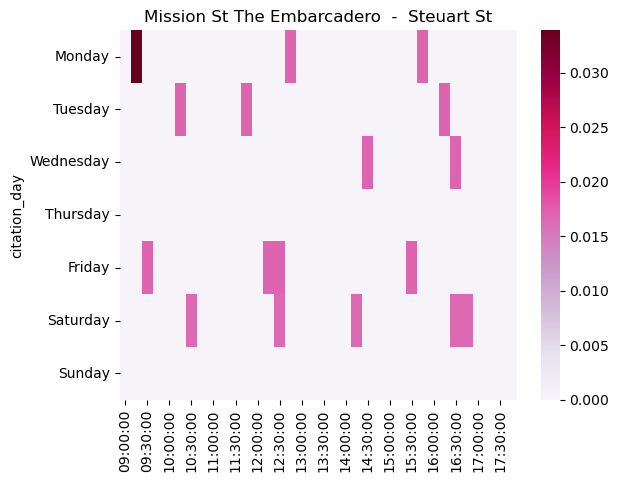

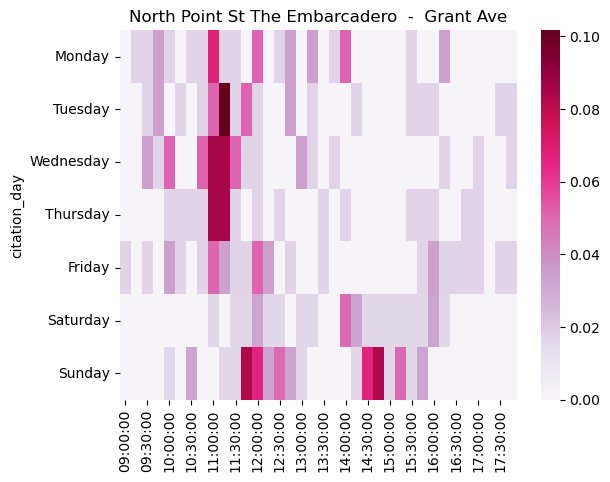

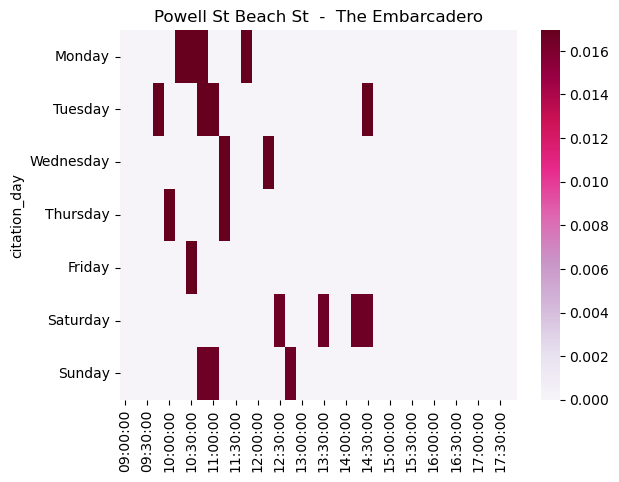

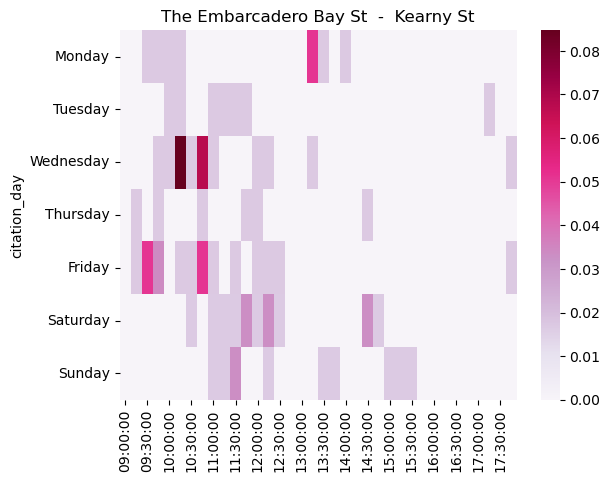

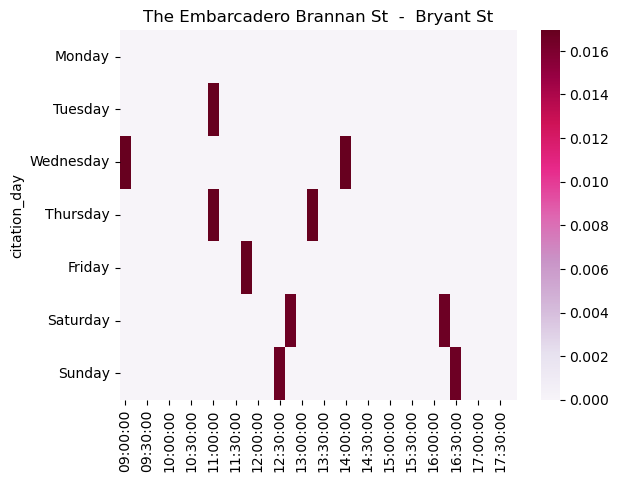

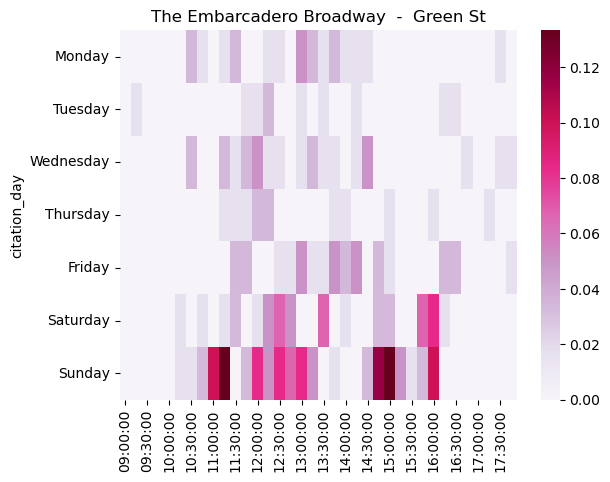

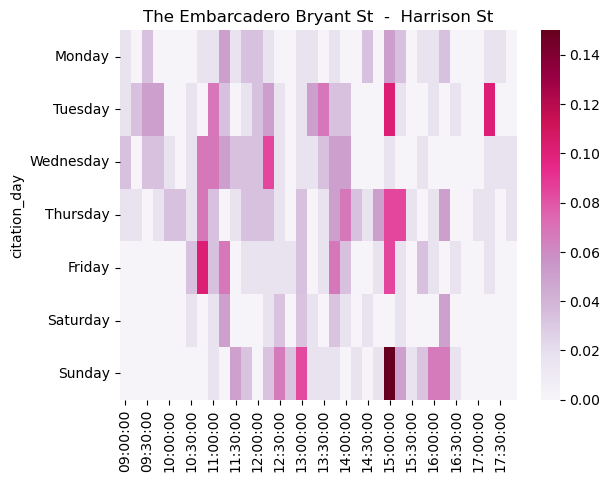

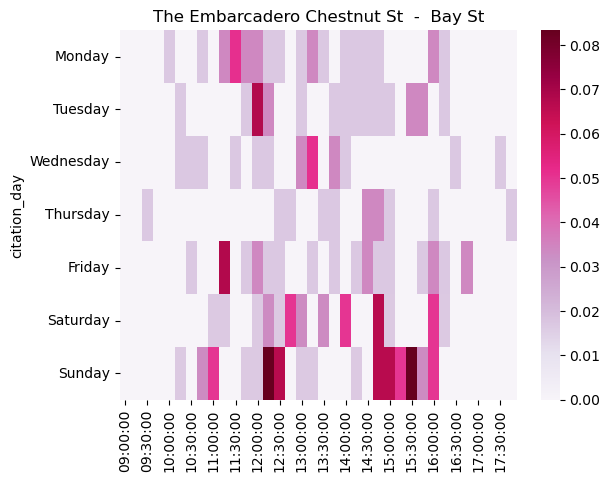

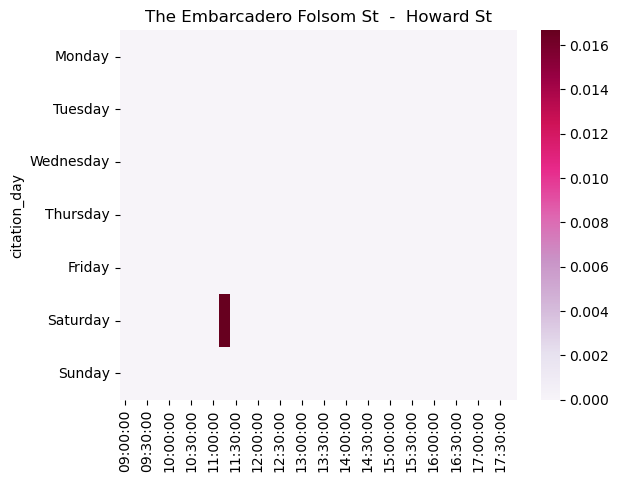

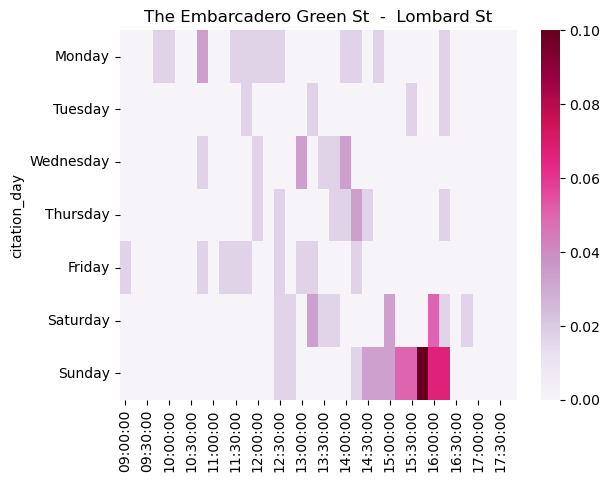

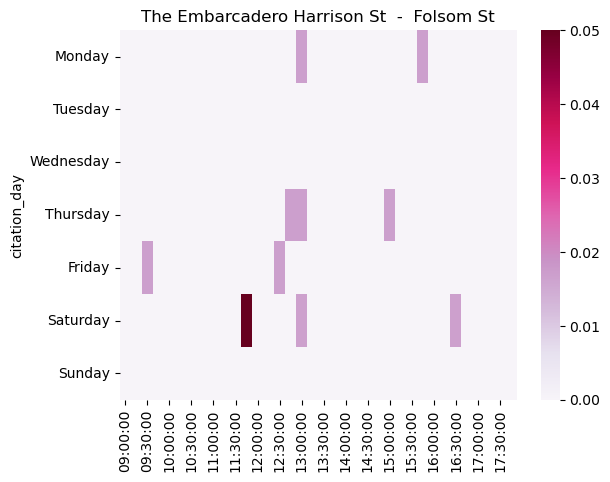

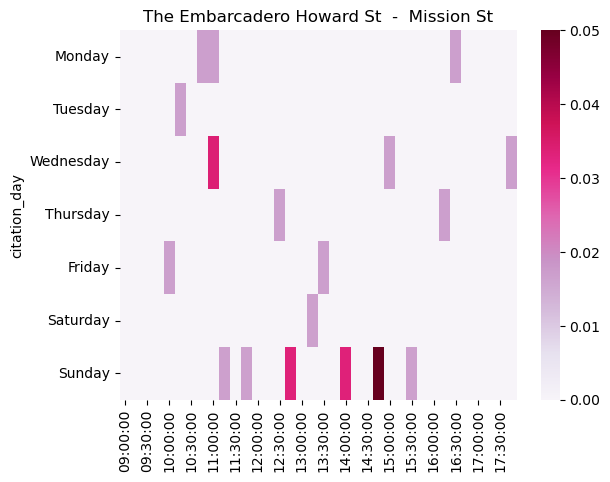

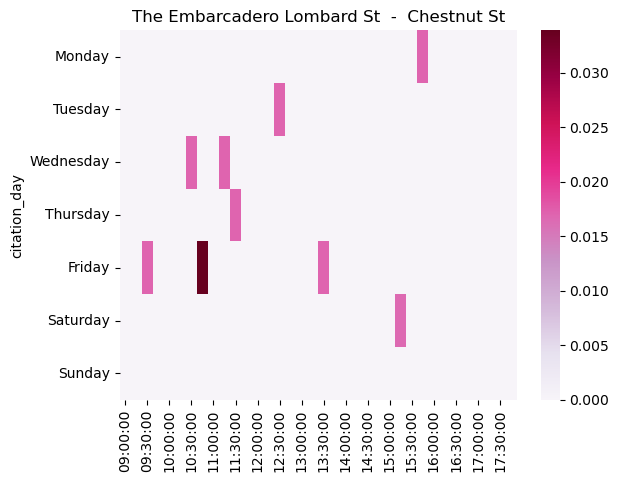

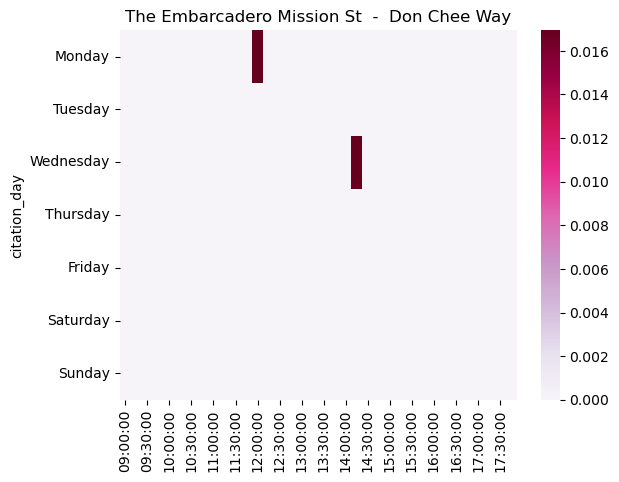

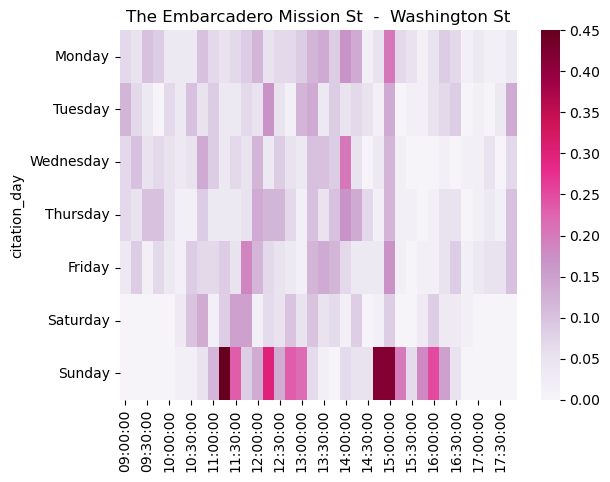

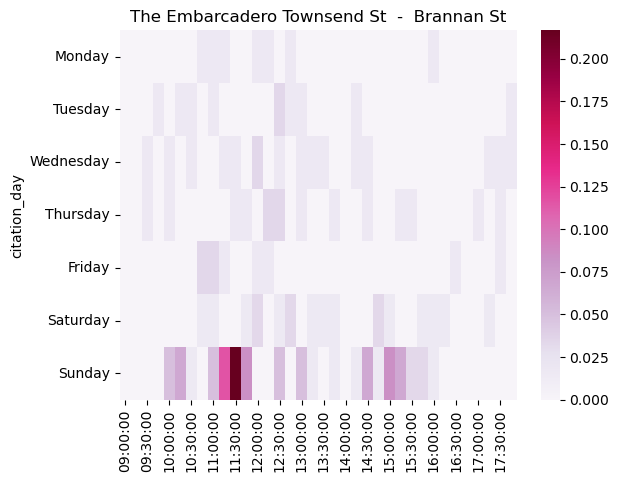

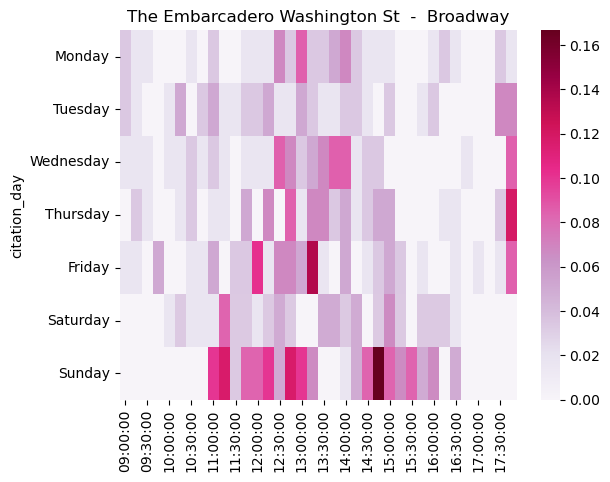

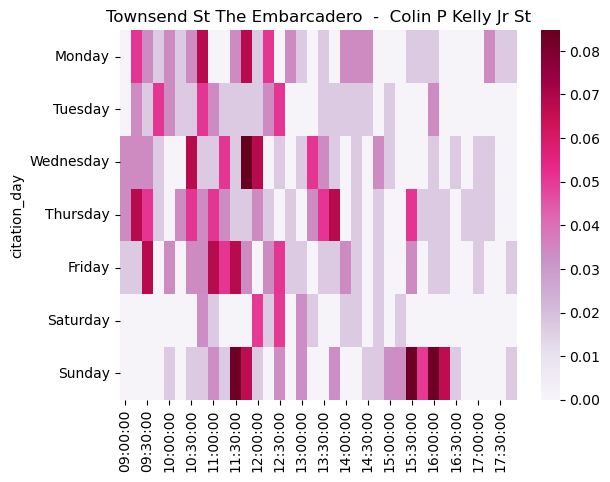

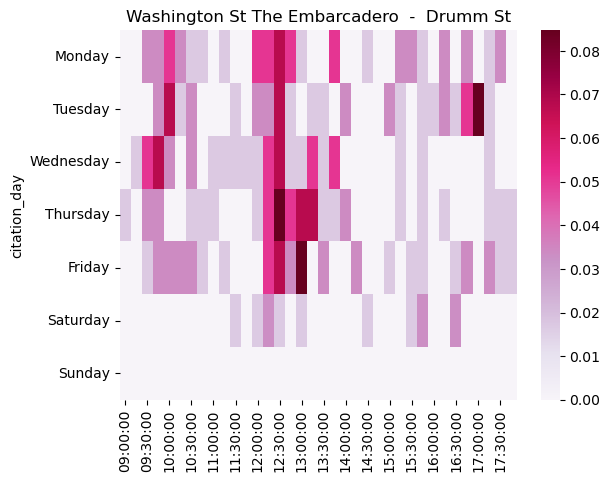

In [143]:

def plot_dist(all_dists, street_id):
    temp_df = all_dists[all_dists.street_id == street_id]
    #print(temp_df)
    # has all 7 days of the week
    assert temp_df.shape[0] == 7
    temp_df = temp_df[[col for col in temp_df.columns if col not in ['street_id', 'time_bin']]]
    temp_df.set_index('citation_day', inplace=True)
    sns.heatmap(temp_df, cmap = "PuRd").set(title=street_id)
    

for street_id in truncated[truncated["street_id"].str.contains("Embarcadero")].street_id.unique():
    plot_dist(truncated, street_id)
    plt.show()


In [ ]:
street_id = all_dists['street_id'].value_counts().index[1000]

plot_dist(all_dists, street_id)

In [ ]:
# looking for one street_id

# all_dists[all_dists.street_id.str.contains('Terry A Francois Blvd')].street_id[0]

In [ ]:
NUMERIC_COLS = [col for col in all_dists.columns if '0' in col]

In [ ]:
# add geom information to all_dists

unique_streets['street_id'] = unique_streets['Corridor'] + ' ' + unique_streets['Limits']
street_geom_dict = pd.Series(unique_streets.Line.values,index=unique_streets.street_id).to_dict()
all_dists['geom'] = all_dists['street_id'].apply(lambda key: street_geom_dict[key])

In [ ]:
all_dists

In [ ]:
# equivalent to pivot_longer in R

pivoted = pd.melt(all_dists, id_vars=['citation_day', 'street_id', 'geom'], value_vars=NUMERIC_COLS, value_name='prob', var_name='time')
pivoted['time'] = pd.to_datetime(pivoted['time'])

In [ ]:
pivoted = pivoted[pivoted["prob"] != 0]

In [ ]:
days = {'Monday': timedelta(days=0), 'Tuesday': timedelta(days=1),
        'Wednesday': timedelta(days=2), "Thursday": timedelta(days=3),
        "Friday": timedelta(days=4), "Saturday": timedelta(days=5),
        "Sunday": timedelta(days=6)}

pivoted["time"] = pivoted.citation_day.apply(lambda x: days[x]) + pivoted["time"]

In [ ]:
pivoted.head(10)

In [ ]:
# save to csv for visualization by kepler GL

pivoted.to_csv('../data/pivoted_for_kgl.csv', index=False)

In [ ]:
pivoted['prob'].value_counts()

In [ ]:
pivoted['prob'].min()